<a href="https://colab.research.google.com/github/Falconwatch/nes_bs_proj/blob/main/Business_stats_project_insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Stats Project
Students: Popova Alena, Podyman Anatoly, Shcherbakov Igor

# Motivation
The primary objective of this study is to analyze how medical insurance companies determine the pricing of their products.

Specifically, we aim to:

*   Identify the key demographic and lifestyle factors influencing insurance charges;
*   Investigate potential evidence of discrimination based on non-financial factors such as smoking habits or region;
*   Explore how the pricing mechanism indirectly highlights risk factors associated with health and lifestyle.

Understanding these patterns is critical not only for insurance companies but also for policymakers and individuals, as it provides insights into the fairness and transparency of insurance pricing models.

Data from: https://www.kaggle.com/datasets/rahulvyasm/medical-insurance-cost-prediction/data

In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("rahulvyasm/medical-insurance-cost-prediction")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/rahulvyasm/medical-insurance-cost-prediction/versions/1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro, normaltest, probplot
from sklearn.model_selection import train_test_split
from statsmodels.stats.diagnostic import linear_reset
from sklearn.metrics import r2_score, mean_absolute_error
import scipy.stats as stats

In [ ]:
np.random.seed(42)

In [ ]:
data = pd.read_csv("/root/.cache/kagglehub/datasets/rahulvyasm/medical-insurance-cost-prediction/versions/1/medical_insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Data Dictionary

| Codename   | Meaning                          | Data Type   | Categories / Measurement                        | Description                                                                                     |
|------------|----------------------------------|-------------|------------------------------------------------|-------------------------------------------------------------------------------------------------|
| Age        | Age of policyholder             | Numerical   | Full years                                     | Represents the age of the policyholder, influencing health-related risk and insurance cost.     |
| Sex        | Sex of policyholder             | Categorical | Female, Male                                   | Gender of the policyholder, potentially related to health risk patterns or pricing assumptions. |
| BMI        | Body Mass Index                 | Numerical   | kg/m²                                         | A measure of body fat calculated as weight divided by height squared, often linked to health risks. |
| Children   | Number of children              | Numerical   | Persons                                       | Number of dependents covered under the policy, potentially influencing insurance costs.         |
| Smoker     | Flag if policyholder smokes     | Categorical | Yes, No                                       | Indicates whether the policyholder smokes, a major factor in determining health risks and costs.|
| Region     | Region of policyholder living   | Categorical | Southeast, Southwest, Northeast, Northwest    | The geographic location of the policyholder, which may reflect cost differences due to local factors. |
| Charges    | Price of insurance - target     | Numerical   | Dollar                                        | The total cost of the insurance policy, serving as the dependent variable in the analysis.      |

In [ ]:
numerical_feats = ["age", "bmi", "children"]
categorical_feats = ["sex", "smoker", "region"]
target = "charges"

#Data Description

##Numerical Variables

This section explores the categorical variables in the dataset by visualizing their distributions using pie charts and analyzing their relationships with the target variable (charges) through violin plots. These visualizations reveal significant differences in charges based on categories like sex, smoker, and region, providing key insights into how these variables influence insurance costs.

###Summary Statistics

In [ ]:
def describe_numerical(df, column):
  desciption = {}
  desciption["mean"] = df[column].mean()
  desciption["median"] = df[column].median()
  desciption["min"] = df[column].min()
  desciption["max"] = df[column].max()
  desciption["na_counts"] = data["age"].isna().sum()
  return desciption
pd.DataFrame({nf:describe_numerical(data, nf) for nf in numerical_feats})

,age,bmi,children
mean,39.109668,30.701349,1.101732
median,39.000000,30.447500,1.000000
min,18.000000,15.960000,0.000000
max,64.000000,53.130000,5.000000
na_counts,0.000000,0.000000,0.000000


###Pairwise Relationships

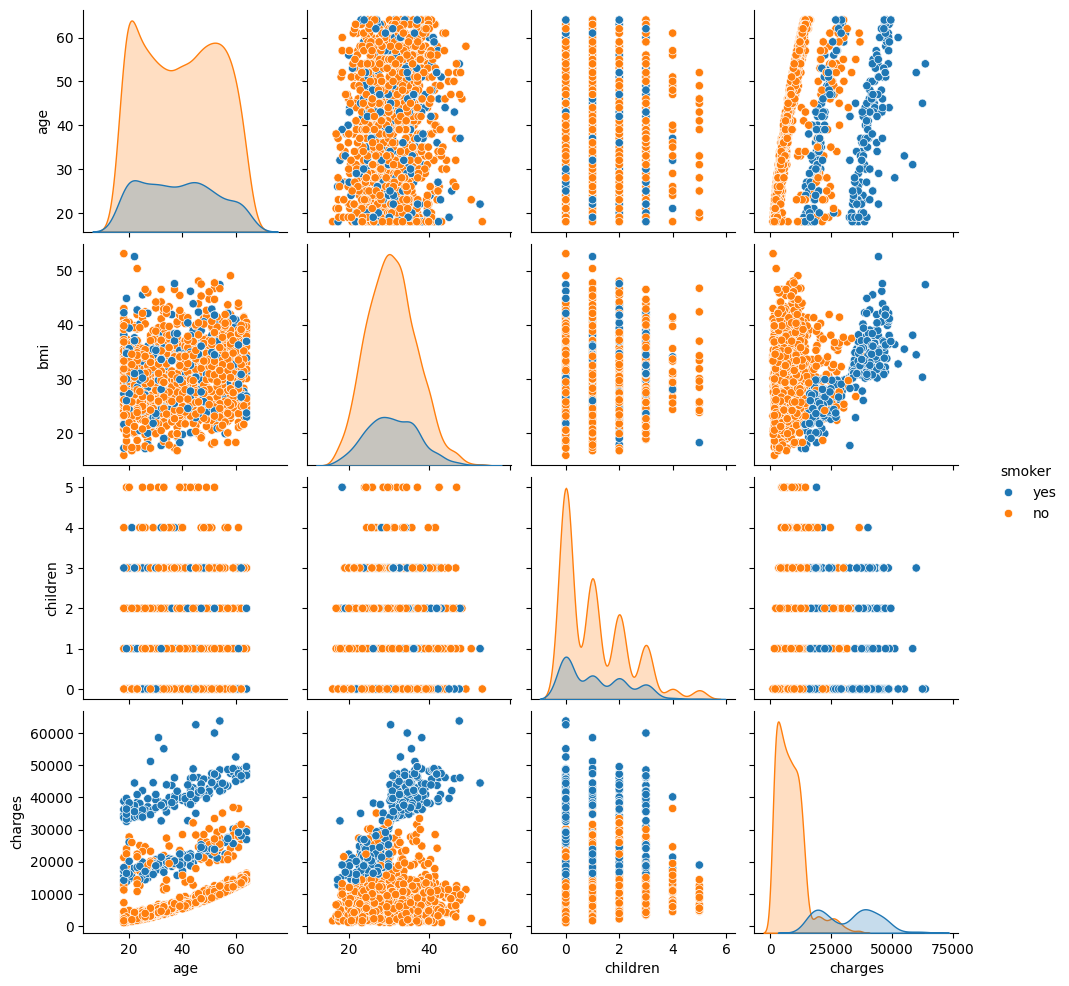

In [ ]:
sns.pairplot(data[numerical_feats+["smoker", target]], hue="smoker")

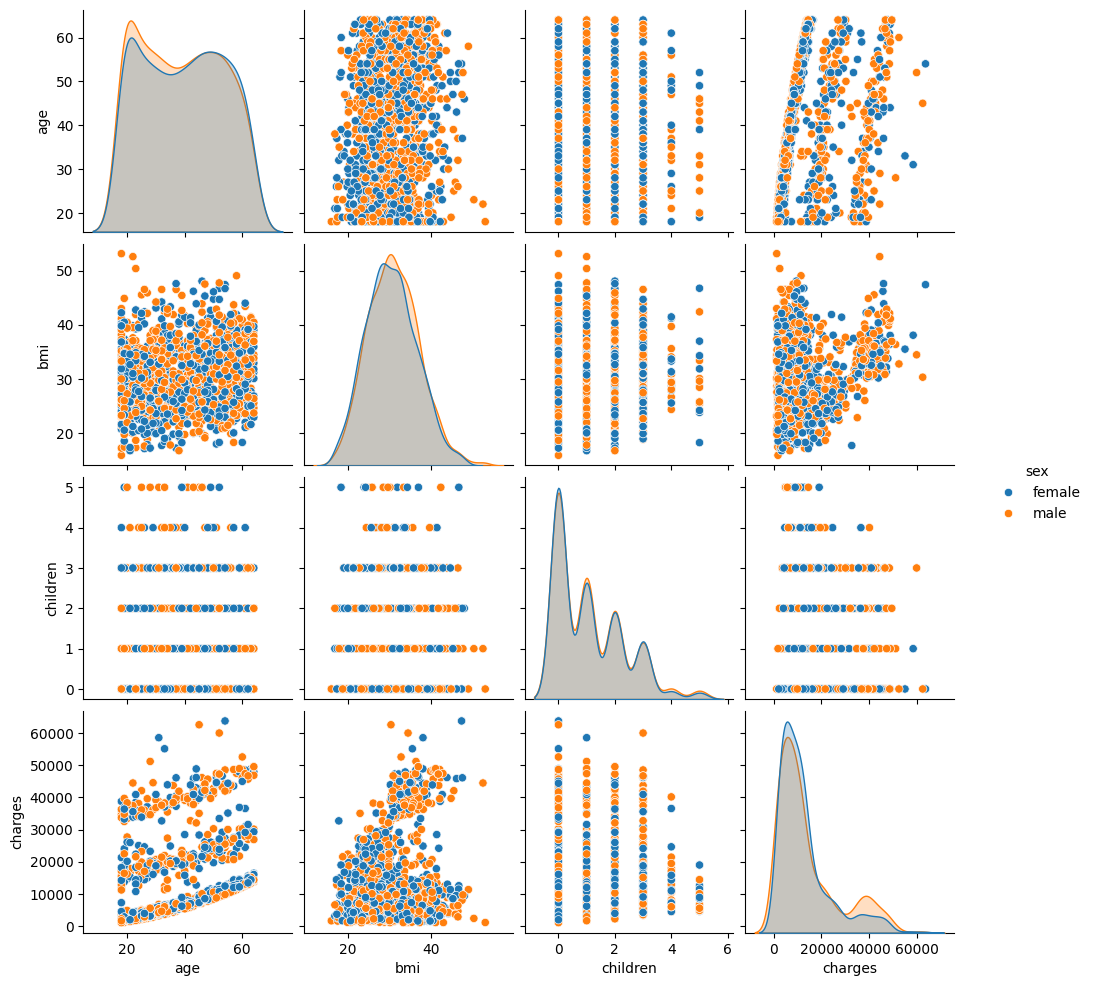

In [ ]:
sns.pairplot(data[numerical_feats+["sex", target]], hue="sex")

###Normality Testing

In [ ]:
def test_normality(column):
    stat_shapiro, p_shapiro = shapiro(data[column])
    stat_dagostino, p_dagostino = normaltest(data[column])
    print(f"Normality Tests for {column}:")
    print(f"Shapiro-Wilk Test: p-value = {p_shapiro:.4f}")
    print(f"D'Agostino’s K-squared Test: p-value = {p_dagostino:.4f}\n")

for col in numerical_feats:
    test_normality(col)

Normality Tests for age:
Shapiro-Wilk Test: p-value = 0.0000
D'Agostino’s K-squared Test: p-value = 0.0000

Normality Tests for bmi:
Shapiro-Wilk Test: p-value = 0.0000
D'Agostino’s K-squared Test: p-value = 0.0000

Normality Tests for children:
Shapiro-Wilk Test: p-value = 0.0000
D'Agostino’s K-squared Test: p-value = 0.0000



Shapiro-Wilk Test and D'Agostino’s K-squared Test both produce p-values = 0.0000.

Since p-values are below the significance level (0.05), we reject the null hypothesis that these variables follow a normal distribution. All tested variables are not normally distributed, which could impact regression assumptions and analysis.

Let's try to make BMI normaly distributed by getting log(BMI)

In [ ]:
data['log_bmi'] = np.log(data['bmi'])

stat_shapiro, p_shapiro = shapiro(data['log_bmi'])
print(f"Log(BMI) Shapiro-Wilk p-value: {p_shapiro:.4f}")

Log(BMI) Shapiro-Wilk p-value: 0.0000


Even after applying the log transformation, log(charges) still does not follow a normal distribution.

##Categorical Variables

This section analyzes categorical variables, visualizing their distributions and exploring their relationships with charges through violin plots. Key insights reveal significant variations in insurance costs based on sex, smoker, and region.

### Distribution

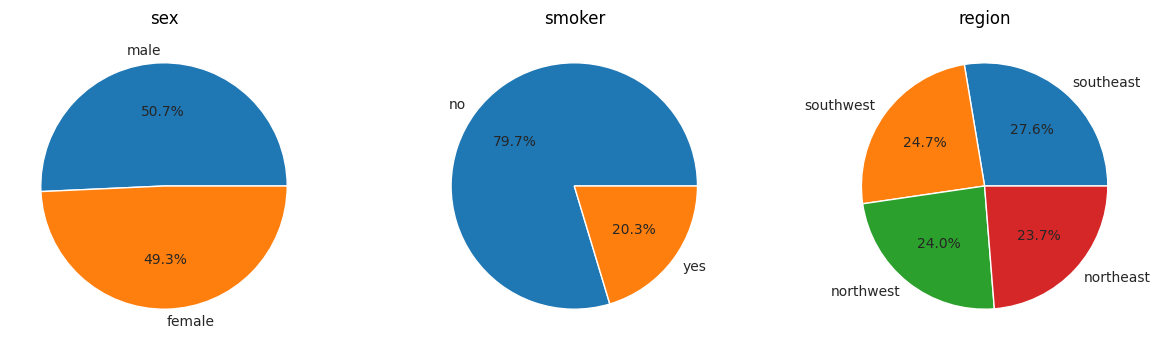

In [ ]:
fix, axes = plt.subplots(1, len(categorical_feats), figsize=[15,4])
sns.set_style("whitegrid")
for i in range(len(categorical_feats)):
  cf_info = data[categorical_feats[i]].value_counts(ascending=False)
  axes[i].pie(cf_info.values, labels=cf_info.index, autopct='%1.1f%%')
  axes[i].set_title(categorical_feats[i])


### Cross-dependecies

<Axes: xlabel='region', ylabel='charges'>

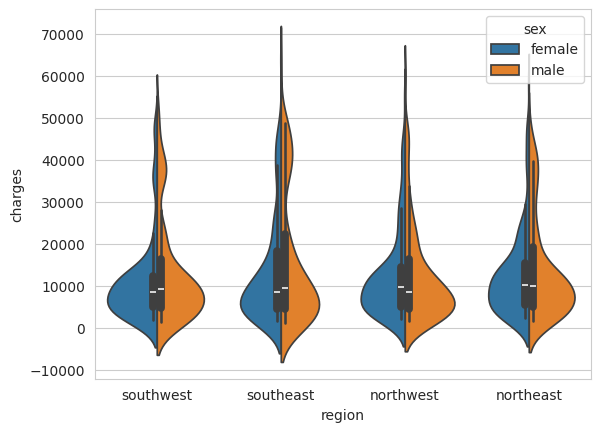

In [ ]:
sns.violinplot(data, x="region", y="charges", split="sex", hue="sex")

<Axes: xlabel='region', ylabel='charges'>

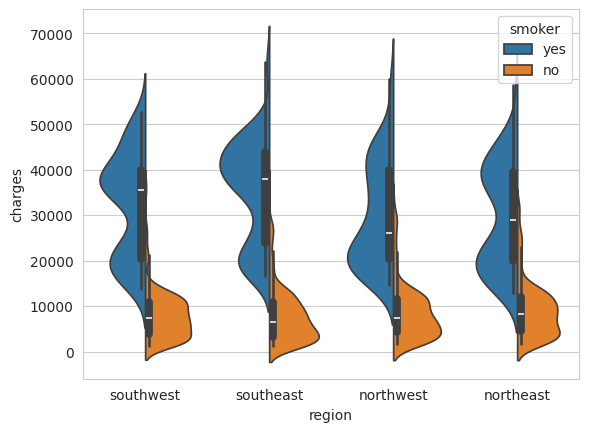

In [ ]:
sns.violinplot(data, x="region", y="charges", split="smoker", hue="smoker")

<Axes: xlabel='sex', ylabel='charges'>

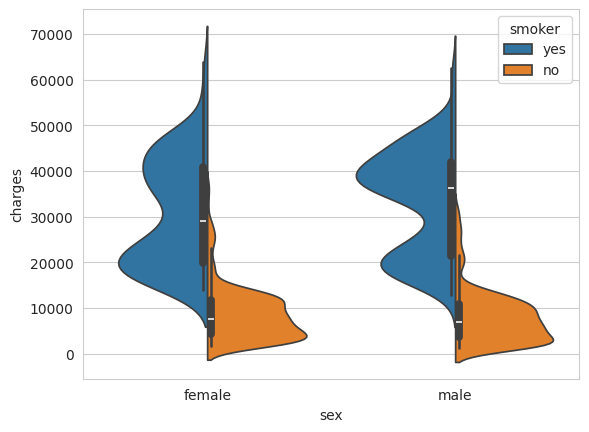

In [ ]:
sns.violinplot(data, x="sex", y="charges", split="smoker", hue="smoker")

## Missing Data

In [ ]:
missing_data = (data.isnull().sum() / len(data)) * 100
print(f"Data missing: \n{missing_data * 100}")

Data missing: 
age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
log_bmi     0.0
dtype: float64


So as no data is missing we may head to further researches

## Multicollinearity Assessment
Assess multicollinearity using Variance Inflation Factor (VIF)

In [ ]:

X = data[numerical_feats].copy()
X.loc[:, 'intercept'] = 1
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

    Variable        VIF
0        age   1.014409
1        bmi   1.012979
2   children   1.001447
3  intercept  31.741567


All VIFs are OK - no multicollinearity found

In [ ]:
def check_categorical_multicollinearity(df, features):
    results = {}
    for i in range(len(features)):
        for j in range(i + 1, len(features)):
            feature1 = features[i]
            feature2 = features[j]
            contingency_table = pd.crosstab(df[feature1], df[feature2])
            chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
            results[(feature1, feature2)] = p
    return results

In [ ]:
check_categorical_multicollinearity(data, categorical_feats)
results = check_categorical_multicollinearity(data, categorical_feats)
if results:
  for pair, p_value in results.items():
    if p_value>0.05:
      print(f"Null hypothesis of independence of the observed frequencies of {pair[0]} and {pair[1]} is NOT REJECTED. P-value = {p_value}")
    else:
      print(f"Null hypothesis of independence of the observed frequencies of {pair[0]} and {pair[1]} REJECTED. P-value = {p_value}")

Null hypothesis of independence of the observed frequencies of sex and smoker REJECTED. P-value = 1.8086889121519203e-05
Null hypothesis of independence of the observed frequencies of sex and region is NOT REJECTED. P-value = 0.6368213125006079
Null hypothesis of independence of the observed frequencies of smoker and region REJECTED. P-value = 0.0006053262237744673


# Regression Analysis

The regression analysis explores the relationship between predictors and charges. Starting with one-factor regressions for each variable, it progresses to multi-factor models, including interaction terms (e.g., smoker * region). Diagnostics such as residual analysis, multicollinearity (VIF), and autocorrelation (Durbin-Watson) ensure model validity. Feature selection using backward elimination refines the model by retaining only significant predictors, revealing key drivers of insurance costs like smoker, age, and bmi.

##One Factor Regression

###Numeric Variables

In [ ]:
for nf in numerical_feats:
  result_nf = smf.ols(formula="charges~"+nf, data=data).fit()
  print(result_nf.summary())
  print()
  print("##############################################################################")

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     271.2
Date:                Wed, 25 Dec 2024   Prob (F-statistic):           3.32e-58
Time:                        10:52:45   Log-Likelihood:                -29875.
No. Observations:                2772   AIC:                         5.975e+04
Df Residuals:                    2770   BIC:                         5.977e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3182.7705    650.450      4.893      0.0

###Categorical Variables

In [ ]:
for cf in categorical_feats:
  result_cf = smf.ols(formula=f"charges~C({cf})", data=data).fit()
  t = result_cf.summary()
  print("##############################################################################")
  print(cf)
  print(t.tables[1])
  print()


##############################################################################
sex
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.249e+04    328.196     38.047      0.000    1.18e+04    1.31e+04
C(sex)[T.male]  1527.0407    460.826      3.314      0.001     623.443    2430.639

##############################################################################
smoker
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         8417.8744    158.987     52.947      0.000    8106.130    8729.619
C(smoker)[T.yes]  2.381e+04    352.467     67.539      0.000    2.31e+04    2.45e+04

##############################################################################
region
                             coef    std err          t      P>|t|     

## Interaction Model

In [ ]:
model_2 = smf.ols(formula="charges~age+bmi+children+C(smoker) * C(region)", data=data).fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     867.3
Date:                Wed, 25 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:52:45   Log-Likelihood:                -28035.
No. Observations:                2772   AIC:                         5.609e+04
Df Residuals:                    2761   BIC:                         5.616e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

##Baseline Model

In [ ]:
model = smf.ols(formula="charges~age+bmi+children+C(smoker)+C(sex)+C(region)", data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     1041.
Date:                Wed, 25 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:52:46   Log-Likelihood:                -28078.
No. Observations:                2772   AIC:                         5.617e+04
Df Residuals:                    2763   BIC:                         5.623e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.16

## Feature Selection
We exclude Sex variable as not significant

We devide region into two variables: north vs south and east bs west

In [ ]:
data["south_north"] = "north"
data.loc[data["region"].isin(["southwest", "southeast"]),"south_north"] = "south"

data["east_west"] = "west"
data.loc[data["region"].isin(["northeast", "southeast"]),"east_west"] = "east"

In [ ]:
model_try_1 = smf.ols(formula="charges~age+bmi+children+C(smoker)*C(south_north)", data=data).fit()
print(model_try_1.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     1442.
Date:                Wed, 25 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:52:46   Log-Likelihood:                -28038.
No. Observations:                2772   AIC:                         5.609e+04
Df Residuals:                    2765   BIC:                         5.613e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [ ]:
model_try_2 = smf.ols(formula="charges~age+bmi+children+C(smoker)*C(sex)+C(south_north)", data=data).fit()
print(model_try_2.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     1200.
Date:                Wed, 25 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:52:46   Log-Likelihood:                -28069.
No. Observations:                2772   AIC:                         5.615e+04
Df Residuals:                    2764   BIC:                         5.620e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [ ]:
model_try_3 = smf.ols(formula="charges~age+bmi+children+C(smoker)+C(region)*C(sex)", data=data).fit()
print(model_try_3.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     756.8
Date:                Wed, 25 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:52:46   Log-Likelihood:                -28077.
No. Observations:                2772   AIC:                         5.618e+04
Df Residuals:                    2760   BIC:                         5.625e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [ ]:
model_try_4 = smf.ols(formula="charges~age+bmi+children+C(smoker)+C(south_north)*C(sex)", data=data).fit()
print(model_try_4.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     1190.
Date:                Wed, 25 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:52:46   Log-Likelihood:                -28078.
No. Observations:                2772   AIC:                         5.617e+04
Df Residuals:                    2764   BIC:                         5.622e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [ ]:
model_try_5 = smf.ols(formula="charges~age+log_bmi+children+C(smoker)+C(south_north)", data=data).fit()
print(model_try_5.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     1671.
Date:                Wed, 25 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:52:46   Log-Likelihood:                -28076.
No. Observations:                2772   AIC:                         5.616e+04
Df Residuals:                    2766   BIC:                         5.620e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -3

In [ ]:
model_try_6 = smf.ols(formula="charges~age+bmi+children+C(smoker)*C(south_north)", data=data).fit()
print(model_try_6.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     1442.
Date:                Wed, 25 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:52:46   Log-Likelihood:                -28038.
No. Observations:                2772   AIC:                         5.609e+04
Df Residuals:                    2765   BIC:                         5.613e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [ ]:
selected_model = smf.ols(formula="charges~age+log_bmi+children+C(smoker)*C(south_north)", data=data).fit()
print(selected_model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     1446.
Date:                Wed, 25 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:52:46   Log-Likelihood:                -28036.
No. Observations:                2772   AIC:                         5.609e+04
Df Residuals:                    2765   BIC:                         5.613e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

We tried different variable combinations and intersections and found final formula specification

Selected model has fewer predictors and bigger R_2 adjusted and also has no unsignificant variables. It means we created more efficient and stable model

## Final Model

In [ ]:
train, test = train_test_split(data)
final_model = smf.ols(formula="charges~age+log_bmi+children+C(smoker)*C(south_north)", data=train).fit()
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     1107.
Date:                Wed, 25 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:52:46   Log-Likelihood:                -20982.
No. Observations:                2079   AIC:                         4.198e+04
Df Residuals:                    2072   BIC:                         4.202e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

##Model Diagnostics
Here we check final model quality

### Quality

In [ ]:
def eval_model(m, dataset):
  redictions = m.predict(dataset)
  r2 = r2_score(y_true = dataset["charges"], y_pred=redictions)
  mae = mean_absolute_error(y_true = dataset["charges"], y_pred=redictions)
  return {"r2":r2, "mae":mae}

In [ ]:
print("Train:")
print(eval_model(final_model, train))

print("Test:")
print(eval_model(final_model, test))

Train:
{'r2': 0.7621401319502755, 'mae': 4035.4923484886763}
Test:
{'r2': 0.747283886759635, 'mae': 4253.7654814832495}


###Log Transformation and Normality Testing

###Residual Analysis
Linear regression assumes normality of residuals, not necessarily predictors. Skewed predictors (like age) can affect the model fit and outliers.

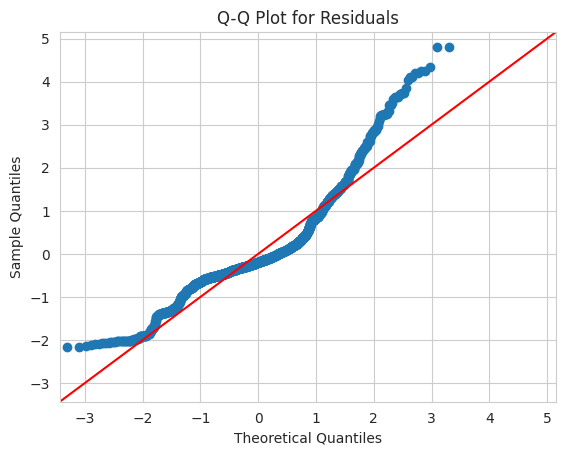

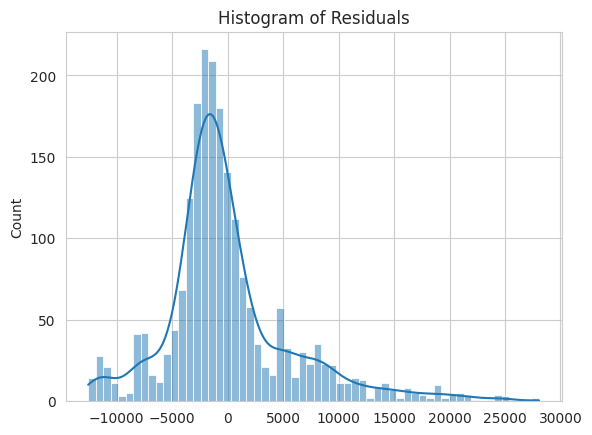

In [ ]:
sm.qqplot(final_model.resid, line="45", fit=True)
plt.title("Q-Q Plot for Residuals")
plt.show()

print("")

sns.histplot(final_model.resid, kde=True)
plt.title("Histogram of Residuals")
plt.show()

The Q-Q plot shows the following key observations:

Deviations at the tails:

The residuals deviate significantly from the red 45-degree line at both the lower (left) and upper (right) tails. This indicates the presence of heavy tails or outliers.

S-Curve Shape:

The residuals curve away from the red line in the middle range as well, suggesting non-normality of residuals.

### F-test

In [ ]:
f_statistic = final_model.fvalue
f_pvalue = final_model.f_pvalue

print(f"F-statistic: {f_statistic:.2f}")
print(f"p-value: {f_pvalue:.2f}")

if f_pvalue < 0.05:
    print("The model is statistically significant")
else:
    print("The model is not statistically significant")

F-statistic: 1106.50
p-value: 0.00
The model is statistically significant


### Outliers

Now checking the Cook's Distance

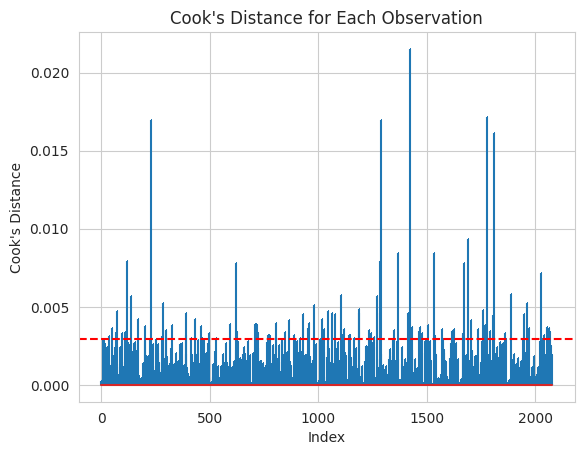

Outliers for Cook's Distance > 0.0030): 4.95 %


In [ ]:
influence = final_model.get_influence()
cooks_d = influence.cooks_distance[0]

threshold = np.percentile(cooks_d, 95)

plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.title("Cook's Distance for Each Observation")
plt.xlabel("Index")
plt.ylabel("Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--')
plt.show()

outliers = np.where(cooks_d > threshold)[0]
print(f"Outliers for Cook's Distance > {threshold:.4f}): {len(outliers) * 100 / len(cooks_d):.2f} %")

### Multicollinearity

In [ ]:
X = data[numerical_feats].copy()
X.loc[:, 'intercept'] = 1
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

    Variable        VIF
0        age   1.014409
1        bmi   1.012979
2   children   1.001447
3  intercept  31.741567


The Variance Inflation Factor (VIF) helps identify multicollinearity issues among predictors.

Variable VIF:

*   age 1.014
*   bmi 1.012
*   children 1.001
*   intercept 31.741

Predictors (age, bmi, children): All have VIF values close to 1. This indicates that multicollinearity is not a problem in the model.

Intercept: A high VIF for the intercept is normal and not an issue. The intercept represents a constant term, which often has inflated VIF because it does not interact with predictors.

All in all, there is no multicollinearity among the independent variables, so the model estimates for age, bmi, and children are stable and reliable.

###Autocorrelation Testing

In [ ]:
_, pval, _, _ = het_breuschpagan(final_model.resid, final_model.model.exog)
print(f"P-value for Breusch-Pagan Test: {pval:.4f}")

if pval < 0.05:
    print("Heteroskedasticity is present (residuals have non-constant variance).")
else:
    print("No heteroskedasticity detected (constant variance of residuals).")

P-value for Breusch-Pagan Test: 0.0000
Heteroskedasticity is present (residuals have non-constant variance).


Interpretation of Breusch-Pagan Test Results P-value = 0.0000: The null hypothesis of homoskedasticity (constant variance of residuals) is rejected. There is heteroskedasticity present, meaning the variance of residuals is not constant across observations.

Implications:

Heteroskedasticity violates one of the key assumptions of linear regression:

It leads to biased standard errors, which in turn affect the significance of coefficients (p-values).

Coefficient estimates remain unbiased, but confidence intervals and t-tests may be unreliable.

In [ ]:
dw_stat = durbin_watson(final_model.resid)
print(f"Durbin-Watson Statistic: {dw_stat:.4f}")

if dw_stat < 1.5:
    print("Positive autocorrelation detected.")
elif dw_stat > 2.5:
    print("Negative autocorrelation detected.")
else:
    print("No significant autocorrelation detected.")

Durbin-Watson Statistic: 1.9468
No significant autocorrelation detected.


Durbin-Watson Statistic = 2.0826: This value is very close to 2, which indicates that there is no significant autocorrelation in the residuals.

The residuals are not correlated with each other, satisfying one of the key assumptions of linear regression.

This result suggests that the model does not suffer from autocorrelation, and the residuals behave as expected.

## Identified Dependencies

In [ ]:
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     1107.
Date:                Wed, 25 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:52:48   Log-Likelihood:                -20982.
No. Observations:                2079   AIC:                         4.198e+04
Df Residuals:                    2072   BIC:                         4.202e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

The significant features in the model are:

Intercept
*   C(smoker)[T.yes] → Being a smoker
significantly increases insurance charges. Smokers pay **21130** more
*   C(south_north)[T.south] → South region has a significant negative effect on charges and reduces charges by **1775**.
*   C(smoker)[T.yes]:C(south_north)[T.south] → Meanwhile smokers from the south pay more then others by **4974**.
*   age → Age significantly increases charges. Every year increases charges by **254**.
*   bmi → Higher BMI significantly increases charges. Every unit in log of BMI increases charges by **9638**.
*   children → Number of children has a positive, significant effect. Every child increses charges by **527**.

#Conclusion

This study aimed to understand how insurance companies price their products by analyzing a dataset of medical insurance charges. The analysis proceeded as follows:

1.   Data Exploration and Description:


*   The dataset included demographic, lifestyle, and regional information for policyholders, along with insurance charges.
*   Summary statistics and visualizations were created for both numerical (age, BMI, children) and categorical (sex, smoker, region) variables. These revealed key trends, such as smokers incurring significantly higher charges.

2.   Regression Analysis:

*   Multiple regression models were estimated, identifying age, BMI, number of children, smoking status, and region as significant predictors of insurance charges.
*   Interaction effects between smoking and region further refined the model, showing how regional disparities influence the impact of smoking on charges.
*   Model diagnostics, including tests for multicollinearity (VIF), heteroskedasticity (Breusch-Pagan test), and autocorrelation (Durbin-Watson), ensured the reliability of the analysis. However, residuals exhibited non-normality and heteroskedasticity, signaling areas for improvement.

3.   Key Findings:

*   Smoking status is the most influential factor, contributing to significantly higher charges, especially in the Southeast and Southwest regions.
*   Age and BMI are consistent predictors, with higher values leading to increased charges. Interestingly, sex had no significant effect when controlling for other variables.

4.   Limitations:

*   The dataset lacks variables like income or medical history, which could improve predictive power.
*   Non-normal residuals and heteroskedasticity violate some linear regression assumptions, potentially affecting inference accuracy.

5.   Future Directions:

*   Expanding the dataset to include additional risk factors or testing non-linear models could enhance the robustness of the analysis.
*   Applying alternative regression techniques (e.g., robust regression or machine learning) may yield more accurate predictions.

Overall, the analysis provides valuable insights into insurance pricing determinants, offering a foundation for more transparent and fair policies. It also highlights the critical role of risk-related factors, such as smoking, in shaping insurance premiums.